# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Eastenders Characters



In [1]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction import DictVectorizer


%matplotlib inline
pd.options.display.max_colwidth=500

In [2]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [3]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # set function is random, need to sort!

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [4]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [5]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [6]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [7]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with eEOL_nd of line _
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [8]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  3848
OTHER Number of Words:  3244
JACK Number of Words:  4435
RONNIE Number of Words:  3442
TANYA Number of Words:  3786
SEAN Number of Words:  3637
ROXY Number of Words:  3838
HEATHER Number of Words:  4098
MAX Number of Words:  4363
IAN Number of Words:  4332
JANE Number of Words:  3648
STACEY Number of Words:  3913
PHIL Number of Words:  3635
MINTY Number of Words:  4005
CHRISTIAN Number of Words:  3738
CLARE Number of Words:  4344
total words 62306


In [9]:
def pre_process(character_text):
    
    #1 lets get lowwercase everything
    #character_text = character_text.lower()
    #this proved to increased the mean rank and does not effect the accurancy so I will keep the letters as they are for the moment
    
    #2 looking at the words I will try to expand the contractions, 
    #for this I build the dictionary with the most common contractions I find in the data
    contractions_dict = {"ain't": "are not","aren't": "are not",
                    "i've":"i have","I'm":"I am","wasn't":"was not",
                    "that's":"that is","it's":"it is",
                   "hasn't":"has not","doesn't":"does not","shouldn't":"should not",
                   "she's":"she is","he's":"he is","i'd":"i would","i'll":"i will"}
    # function for finding contractions
    contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    def expand_contractions(text,contractions_dict=contractions_dict):
        def replace(match):
            return contractions_dict[match.group(0)]
        return contractions_re.sub(replace, text)
    # Expanding Contractions to the text
    character_text=expand_contractions(character_text)
    
    #3 Now I will try to remove the puncuation to see how it effects ,y mean rank
    #remove punctuation
    # initializing punctuations string
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*~'''#here I just remove the underscore not to effect the _EOL_ at the end pf lines
    # Removing punctuations in string
    # Using loop + punctuation string
    for ele in character_text:
        if ele in punc:
            character_text = character_text.replace(ele, "")
            
    #4 removing stop words
    #remove stopwords
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.add('subject')
    stop_words.add('http')
    def remove_stopwords(text):
        return " ".join([word for word in str(text).split() if word not in stop_words])
    character_text =remove_stopwords(character_text)
    
    """#5 Lemmatization
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(text):
        return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    character_text =lemmatize_words(character_text)
    #6 Convert number word to digits
    num_dict = {"one":"1","two":"2","three":"3","four":"4","five":"5",
                   "six":"6","seven":"7","eight":"8","nine":"9","ten":"10"}
    # function for finding number words
    num_re=re.compile('(%s)' % '|'.join(num_dict.keys()))
    def replace_nums(text,num_dict=num_dict):
        def replace(match):
            return num_dict[match.group(0)]
        return num_re.sub(replace, text)
    character_text=replace_nums(character_text)
    """
    #I commented out the normalization,lowercasing and addin digits for number words because they dont improve our mean.
    
    
    # just a simple tokenization, to be replaced
    tokens = character_text.split() 
    return tokens
    

In [10]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [11]:
pip install vaderSentiment #this is used in the feature vector function below for sentiment analysis

Note: you may need to restart the kernel to use updated packages.


In [12]:
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    
    # adding post_taggs as features
    tagged=[(token,pos_tag) for token, pos_tag in nltk.pos_tag(character_doc)]
    tagged_str=[str(tagged_w) for tagged_w in tagged]
    pos_count=Counter(tagged_str)
    counts.update(pos_count)
    
       
    # adding bigrams
    from nltk.util import ngrams
    n_doc=' '.join([str(single) for single in character_doc])
    ngram_doc=n_doc.split()
    bigrams=[token for token in ngrams(ngram_doc,2)]
    bigrams=[str(pairs) for pairs in bigrams]
    bigram_counts=Counter(bigrams)
    bigram_counts=dict(bigram_counts)
    counts.update(bigram_counts)
    #extracting trigrams
    #trigrams=[token for token in ngrams(ngram_doc,3)]
    #trigrams=[str(trio) for trio in trigrams]
    #trigram_counts=Counter(trigrams)
    #trigram_counts=dict(trigram_counts)
    #counts.update(trigram_counts)
   
    #sentiment score using Vader sentiment score, I am using just the compound score initially resulted in
    #a massive increase in mean rank, so I changed it to neu,neg or pos names. it increases the mean a little but we have a slight increase in cos similarity
    """
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    sid_obj = SentimentIntensityAnalyzer()
    #function for getting  the sentiment and giving sentiment to the word
    
    def sentiment_check(token_list):
            #using chunks since the nltk needs single sentences in string
            #divide the token list in single token chunks and get sentiment of each word
            
            chunks = [token_list[x:x+1] for x in range(0, len(token_list), 1)]
            s={}
            for l in chunks:
                score=sid_obj.polarity_scores(l)
                #scores come in dict type and have 4 keys,I am using coumpund key value to get the sentiment
                for each_token in l:
                    if score['compound']>= 0.05:
                        s[each_token]='Positive'
                    elif score['compound']<= -0.05:
                        s[each_token]='Negative'
                    else:
                        s[each_token]='Neutral'
            return s
    sc=sentiment_check(character_doc)#perform function on the token list
    sc= [(k, sc[k]) for k in sc]#get the key,value pairs and then get the in a string
    sc=[str(pair) for pair in sc]
    s_counts=Counter(sc)
    s_counts=dict(s_counts)
    counts.update(s_counts)
    """
    for feature in extra_features:
        counts[feature] += 1
    return counts 

In [13]:
#just checking the dictionary output for the features
a=[(name,to_feature_vector_dictionary(doc)) for name, doc in training_corpus]
str(a[1])

'(\'CLARE\', {\'Dot\': 14, \'_EOL_\': 352, \'Wheres\': 1, \'Do\': 5, \'people\': 2, \'still\': 4, \'use\': 3, \'place\': 6, \'And\': 13, \'Pauline\': 2, \'Something\': 1, \'like\': 23, \'I\': 186, \'didnt\': 7, \'waiting\': 4, \'someone\': 5, \'The\': 8, \'fella\': 1, \'runs\': 1, \'Does\': 1, \'live\': 1, \'round\': 4, \'Bit\': 1, \'comedown\': 1, \'one\': 15, \'remember\': 3, \'Bacon\': 1, \'sandwich\': 1, \'Please\': 3, \'Not\': 5, \'really\': 22, \'Listener\': 1, \'dont\': 19, \'suppose\': 4, \'could\': 16, \'lend\': 1, \'cash\': 3, \'ya\': 1, \'Just\': 11, \'get\': 31, \'Come\': 2, \'Ian\': 11, \'You\': 27, \'chucked\': 1, \'Sonia\': 1, \'cafe\': 3, \'enough\': 3, \'times\': 4, \'little\': 3, \'tried\': 2, \'call\': 3, \'My\': 5, \'boyfriend\': 3, \'exboyfriend\': 1, \'All\': 2, \'need\': 10, \'somewhere\': 4, \'clean\': 1, \'Ive\': 17, \'got\': 16, \'nowhere\': 1, \'else\': 1, \'go\': 17, \'mean\': 6, \'As\': 2, \'soon\': 2, \'next\': 2, \'train\': 1, \'Look\': 14, \'gotta\': 5, 

In [14]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    
  
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [15]:
training_feature_matrix

<16x36183 sparse matrix of type '<class 'numpy.float64'>'
	with 63249 stored elements in Compressed Sparse Row format>

In [16]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405
total words 7062


In [17]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [18]:
val_feature_matrix

<16x36183 sparse matrix of type '<class 'numpy.float64'>'
	with 6810 stored elements in Compressed Sparse Row format>

In [19]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [20]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [21]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [22]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 2.5625
mean cosine similarity 0.8903672531773484
10 correct out of 16 / accuracy: 0.625


In [34]:
repor_preproBest=compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
pd.DataFrame(repor_preprocBest)

mean rank 2.5625
mean cosine similarity 0.8903672531773484
10 correct out of 16 / accuracy: 0.625


NameError: name 'repor_preprocBest' is not defined

In [23]:
repor_prepro1=compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
pd.DataFrame(repor_preproc1)

mean rank 2.625
mean cosine similarity 0.8640474335847284
9 correct out of 16 / accuracy: 0.5625


NameError: name 'repor_preproc1' is not defined

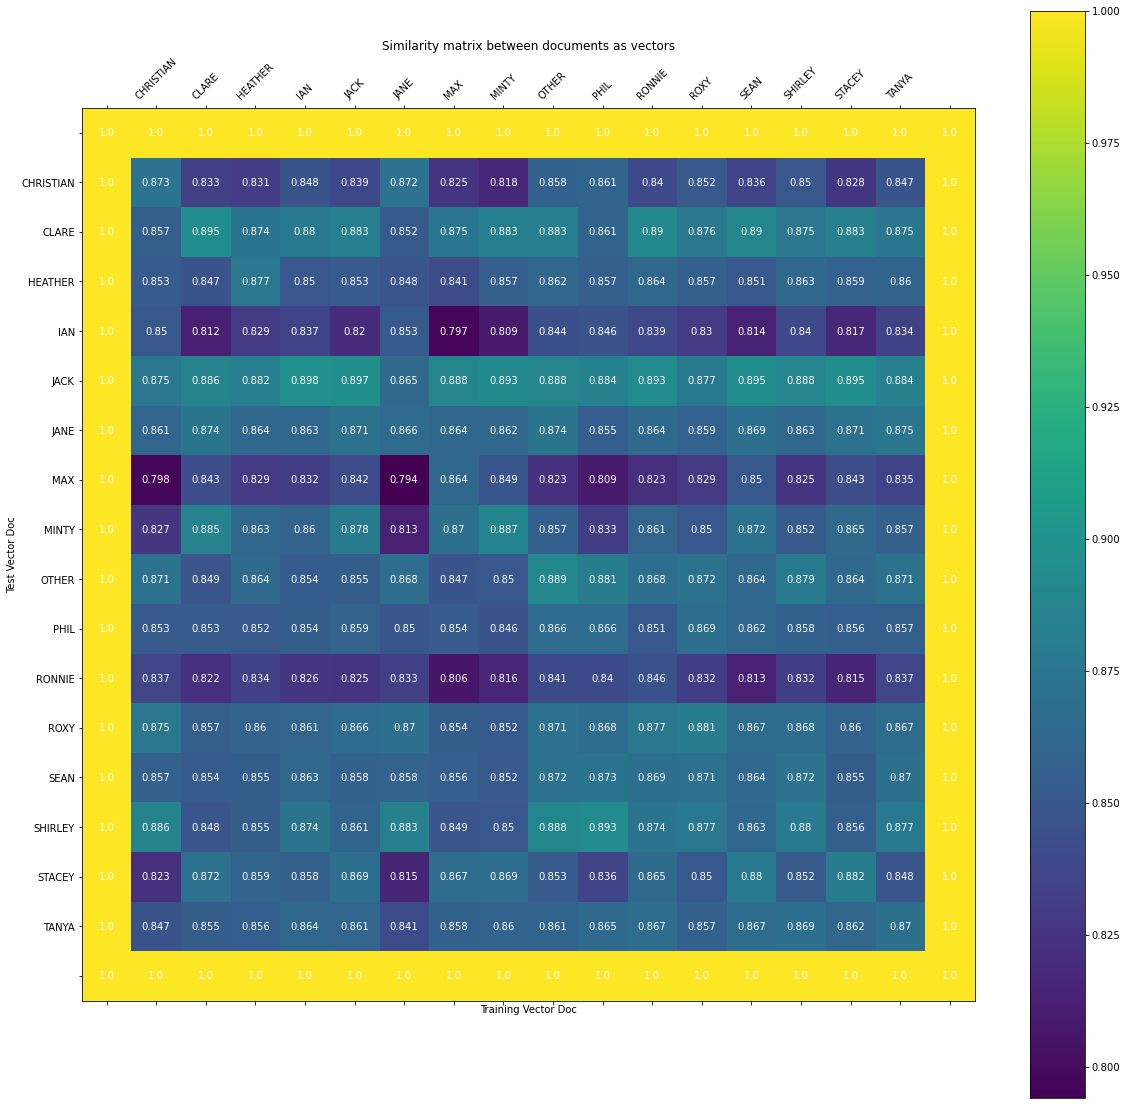

In [23]:
plot_heat_map_similarity(df)

# Q1. Improve pre-processing (10 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially the code in this template achieves a mean rank of **5.12**  and accuracy of **0.3125** on the test set- you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


# Q2. Improve linguistic feature extraction (15 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. You could also use sentiment analysis and gender classification (using the same data) as additional features.

You could use some feature selection/reduction with techniques like minimum document frequency and/or feature selection like k-best selection using different criteria https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

# Q3. Add dialogue context data and features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (immediately before and after). You can also use **scene information** from the other columns **(but NOT the gender and character names directly)**.

# Q4. Improve the vectorization method (10 marks)
Use a matrix transformation technique like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizor (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

As the `create_document_matrix_from_corpus` is designed to be used both in training/fitting (with `fitting` set to `True`) and in transformation alone on test/validation data (with `fitting` set to `False`), make sure you initialize any transformers you want to try in the same place as `corpusVectorizer = DictVectorizer()` before you call 
`create_document_matrix_from_corpus`. Again, develop on 90% training 10% validation split and note the effect/improvement in mean rank with each technique you try.

# Q5. Select and test the best vector representation method (10 marks)
Finish the optimization of your vector representations by selecting the best combination of the techniques you tried in Q1-3 and test using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

In [23]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  4233
OTHER Number of Words:  3606
JACK Number of Words:  4786
RONNIE Number of Words:  3872
TANYA Number of Words:  4214
SEAN Number of Words:  4026
ROXY Number of Words:  4200
HEATHER Number of Words:  4504
MAX Number of Words:  5107
IAN Number of Words:  4863
JANE Number of Words:  4117
STACEY Number of Words:  4325
PHIL Number of Words:  4103
MINTY Number of Words:  4391
CHRISTIAN Number of Words:  4250
CLARE Number of Words:  4844
total words 69441
lines per character {'SHIRLEY': 40, 'OTHER': 40, 'HEATHER': 40, 'PHIL': 40, 'SEAN': 40, 'TANYA': 40, 'MAX': 40, 'JACK': 40, 'IAN': 40, 'JANE': 40, 'STACEY': 40, 'ROXY': 40, 'RONNIE': 40, 'CHRISTIAN': 40, 'MINTY': 40, 'CLARE': 40}
Num. Characters:  